In [1]:
#imports 

import csv
import os
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
#import tensorflow_text as text 

from opencage.geocoder import OpenCageGeocode
from langdetect import detect, LangDetectException


import keras
import keras.utils
import keras.layers
import keras.models
import keras.optimizers
from keras import utils as np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

In [4]:
raw_data = pd.read_csv('.../data/full_df.csv')

#remove null values (missed/blocked scrapes)
raw_data['text'] = raw_data['text'].str.strip() 
raw_data.dropna(subset=['text'], inplace=True)
null_counts = raw_data.isnull().sum()
#print(null_counts)

print(raw_data.shape)
print(raw_data.head(5))

In [ ]:
df_1 = raw_data
#Count occurrences of each country
country_counts = df_1['Country'].value_counts()
#print(country_counts)

# Count occurrences of each country
continent_counts = df_1['Continent'].value_counts()
print(continent_counts)

# Count occurrences of each state
state_counts = df_1['State'].value_counts()
#print(state_counts)

global_average = df_1['sentiment'].mean()

print(global_average)

Continent
North America    5004
Europe            999
Oceania           390
Asia              137
South America      49
Africa             28
Name: count, dtype: int64
-0.037884861152889554


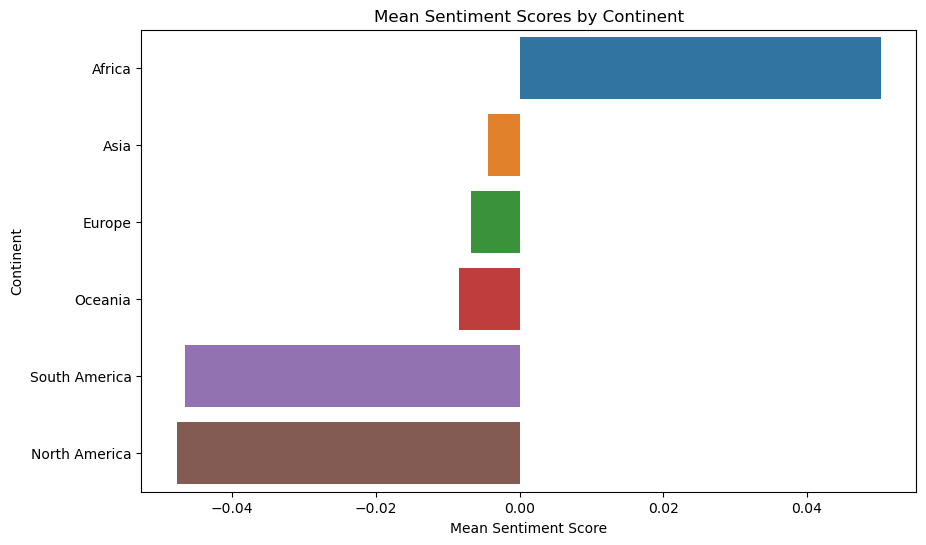

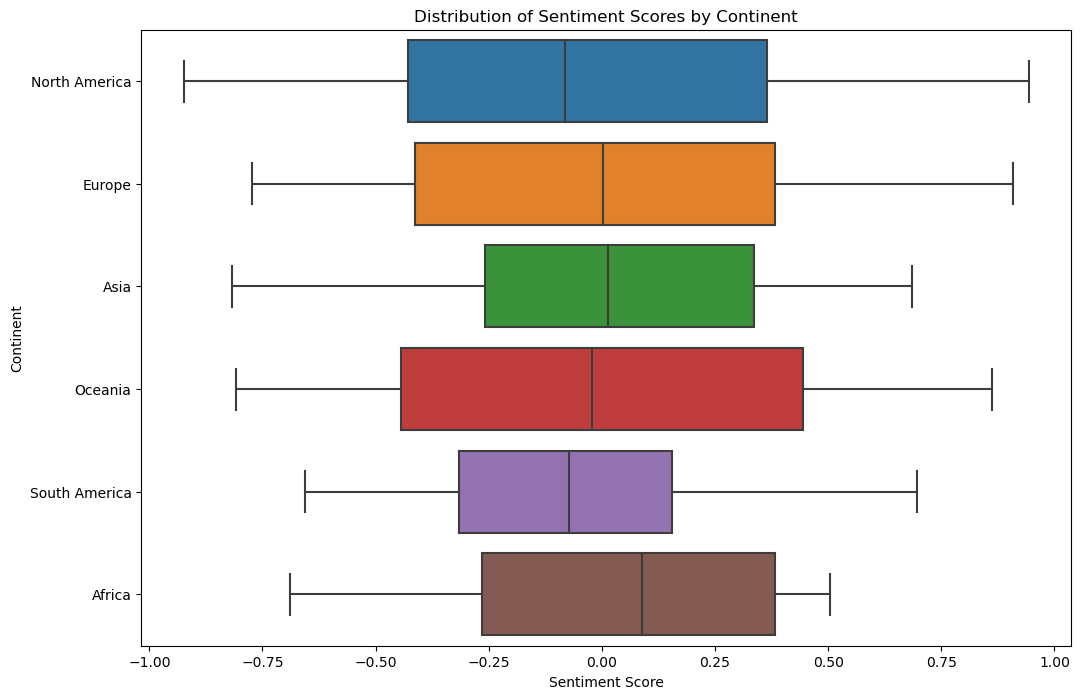

In [ ]:
country_scores = df_1.groupby('Country')['sentiment'].mean().reset_index()
continent_scores = df_1.groupby('Continent')['sentiment'].mean().reset_index()

# Visualize mean sentiment scores by Country
#plt.figure(figsize=(10, 6))
#sns.barplot(x='sentiment', y='Country', data=country_scores.sort_values(by='sentiment', ascending=False))
#plt.title('Mean Sentiment Scores by Country')
#plt.xlabel('Mean Sentiment Score')
#plt.ylabel('Country')
#plt.show()


# Visualize mean sentiment scores by Continent
plt.figure(figsize=(10, 6))
sns.barplot(x='sentiment', y='Continent', data=continent_scores.sort_values(by='sentiment', ascending=False))
plt.title('Mean Sentiment Scores by Continent')
plt.xlabel('Mean Sentiment Score')
plt.ylabel('Continent')
plt.show()

# Visualize the distribution of sentiment scores by Country
#plt.figure(figsize=(12, 8))
#sns.boxplot(x='sentiment', y='Country', data=df_1)
#plt.title('Distribution of Sentiment Scores by Country')
#plt.xlabel('Sentiment Score')
#plt.ylabel('Country')
#plt.show()

# Visualize the distribution of sentiment scores by Continent
plt.figure(figsize=(12, 8))
sns.boxplot(x='sentiment', y='Continent', data=df_1)
plt.title('Distribution of Sentiment Scores by Continent')
plt.xlabel('Sentiment Score')
plt.ylabel('Continent')
plt.show()

In [ ]:
def is_english(text):
    try:
        # Detect the language of the text
        return detect(text) == 'en'
    except LangDetectException:
        # Handle cases where language detection fails
        return False
    
df_1['is_english'] = df_1['text'].apply(is_english)

english_counts = df_1['is_english'].value_counts()

print(english_counts)



is_english
True     6490
False     117
Name: count, dtype: int64


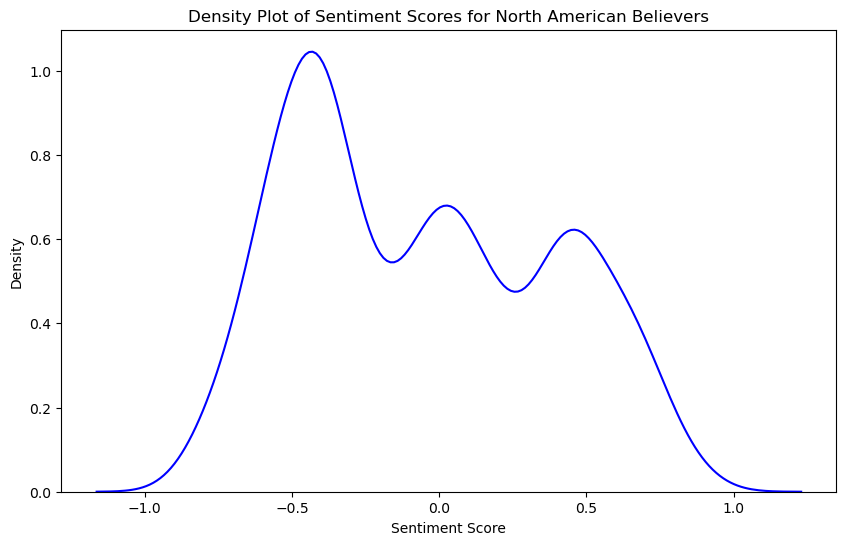

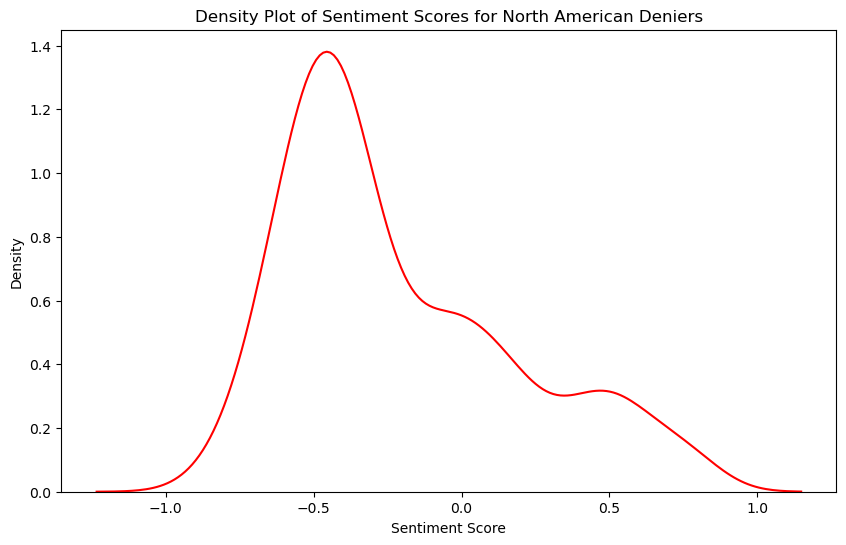

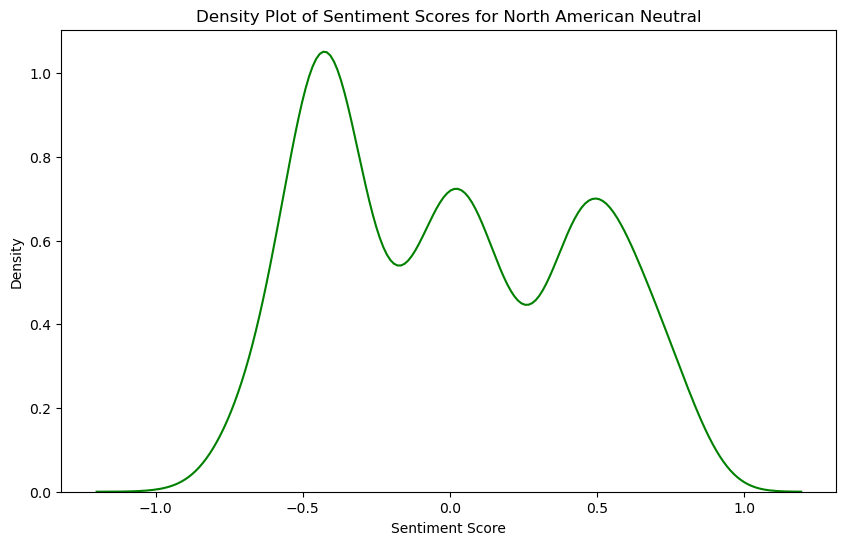

In [ ]:
north_america = df_1[df_1['Continent'] == 'North America']
believers_na = north_america[north_america['stance'] == 'believer']
deniers_na = north_america[north_america['stance'] == 'denier']
neutral_na = north_america[north_america['stance'] == 'neutral']

# KDE Plot for North American Believers
plt.figure(figsize=(10, 6))
sns.kdeplot(believers_na['sentiment'], color="b")
plt.title('Density Plot of Sentiment Scores for North American Believers')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

# KDE Plot for North American Deniers
plt.figure(figsize=(10, 6))
sns.kdeplot(deniers_na['sentiment'], color="r")
plt.title('Density Plot of Sentiment Scores for North American Deniers')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

# KDE Plot for North American Neutral
plt.figure(figsize=(10, 6))
sns.kdeplot(neutral_na['sentiment'], color="g")
plt.title('Density Plot of Sentiment Scores for North American Neutral')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

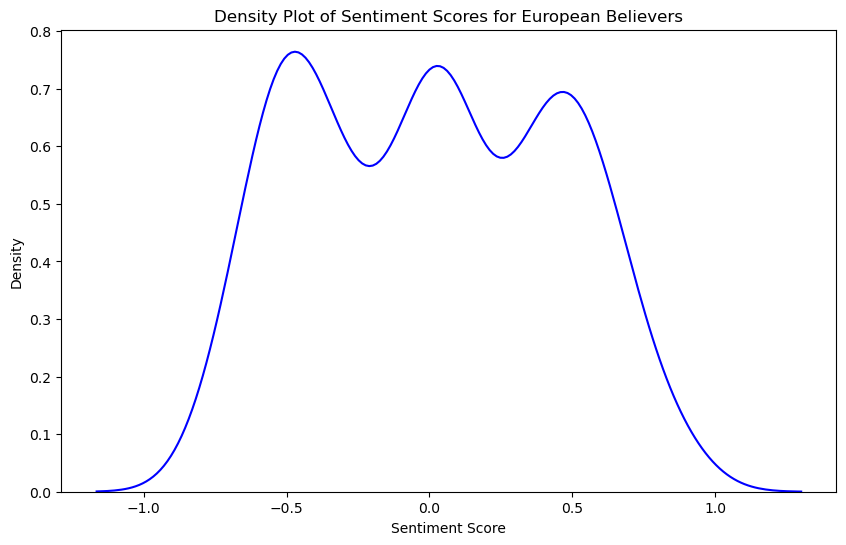

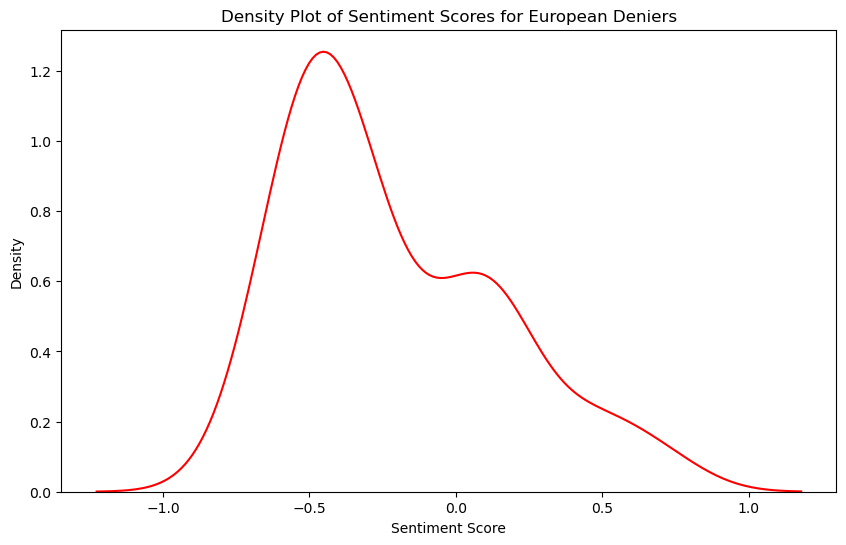

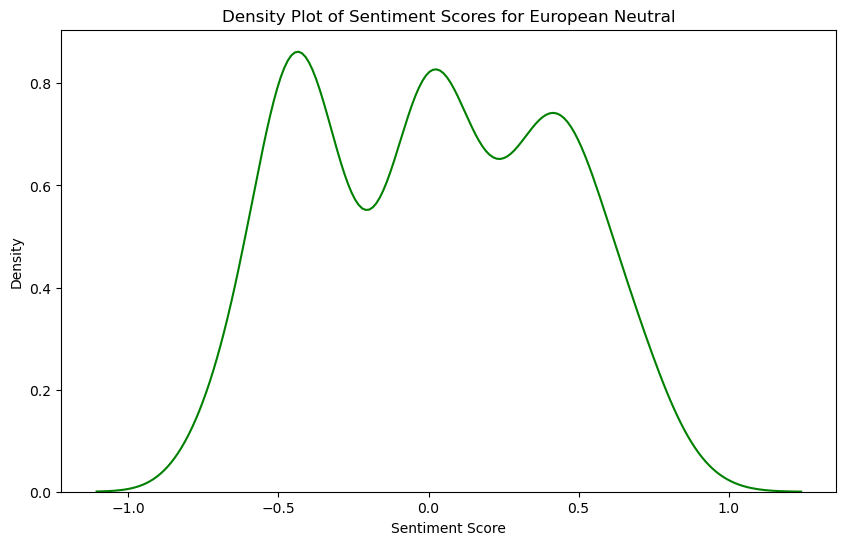

In [ ]:
europe = df_1[df_1['Continent'] == 'Europe']
believers_eu = europe[europe['stance'] == 'believer']
deniers_eu = europe[europe['stance'] == 'denier']
neutral_eu = europe[europe['stance'] == 'neutral']

# KDE Plot for European Believers
plt.figure(figsize=(10, 6))
sns.kdeplot(believers_eu['sentiment'], color="blue")
plt.title('Density Plot of Sentiment Scores for European Believers')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

# KDE Plot for European Deniers
plt.figure(figsize=(10, 6))
sns.kdeplot(deniers_eu['sentiment'], color="red")
plt.title('Density Plot of Sentiment Scores for European Deniers')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

# KDE Plot for European Neutral
plt.figure(figsize=(10, 6))
sns.kdeplot(neutral_eu['sentiment'], color="green")
plt.title('Density Plot of Sentiment Scores for European Neutral')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

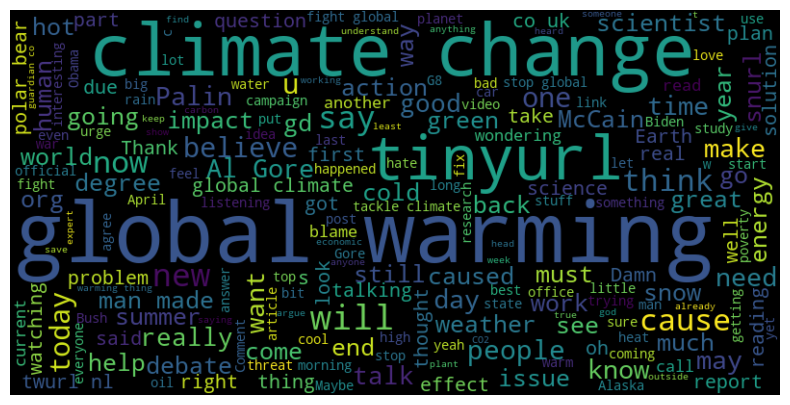

In [ ]:
from wordcloud import WordCloud

# Generate a word cloud
text = ' '.join(df_1['text'].dropna())
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

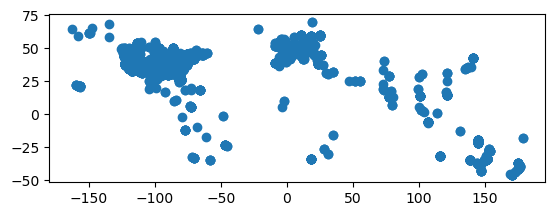

In [ ]:
import geopandas as gpd
import folium

gdf = gpd.GeoDataFrame(df_1, geometry=gpd.points_from_xy(df_1.lng, df_1.lat)) #geopandas map function implementation
gdf.plot()
plt.show()

m = folium.Map(location=[df_1['lat'].mean(), df_1['lng'].mean()], zoom_start=6) #html map to see datapoints
for idx, row in df_1.iterrows():
    folium.Marker([row['lat'], row['lng']]).add_to(m)
m.save('map.html')

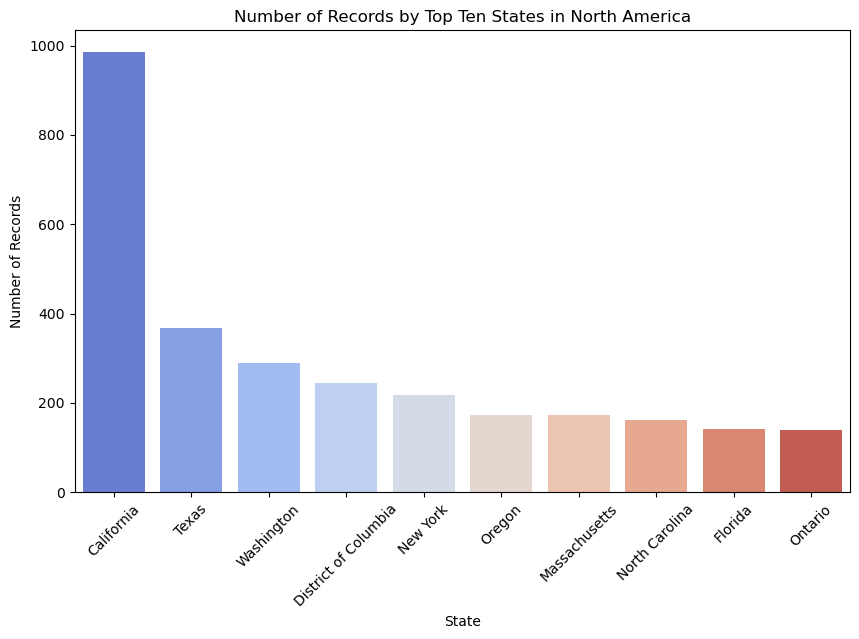

In [ ]:
north_america_countries = ['United States', 'Canada', 'Mexico']
df_na = df_1[df_1['Country'].isin(north_america_countries)]
state_counts = df_na.groupby('State').size().sort_values(ascending=False)
top_ten_states_by_records = state_counts.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_ten_states_by_records.index, y=top_ten_states_by_records.values, palette='coolwarm')
plt.title('Number of Records by Top Ten States in North America')
plt.xlabel('State')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#Subset Creation for NA Data

region_mapping = {
    # Northeast North America
    'Maine': 'Northeast North America', 'New Hampshire': 'Northeast North America', 
    'Vermont': 'Northeast North America', 'Massachusetts': 'Northeast North America', 
    'Rhode Island': 'Northeast North America', 'Connecticut': 'Northeast North America', 
    'New York': 'Northeast North America', 'New Jersey': 'Northeast North America', 
    'Pennsylvania': 'Northeast North America', 'Quebec': 'Northeast North America', 
    'New Brunswick': 'Northeast North America', 'Nova Scotia': 'Northeast North America', 
    'Prince Edward Island': 'Northeast North America', 'Newfoundland and Labrador': 'Northeast North America',
    'Ontario': 'Northeast North America', 'Tamaulipas': 'Northeast North America',
    
    # Southeast North America
    'Maryland': 'Southeast North America', 'Delaware': 'Southeast North America', 
    'Virginia': 'Southeast North America', 'West Virginia': 'Southeast North America', 
    'North Carolina': 'Southeast North America', 'South Carolina': 'Southeast North America', 
    'Georgia': 'Southeast North America', 'Florida': 'Southeast North America', 
    'Alabama': 'Southeast North America', 'Mississippi': 'Southeast North America', 
    'Louisiana': 'Southeast North America', 'Texas': 'Southeast North America', 
    'Veracruz': 'Southeast North America', 'Yucatan': 'Southeast North America', 
    'Quintana Roo': 'Southeast North America', 'Campeche': 'Southeast North America',
    
    # Northwest North America
    'Washington': 'Northwest North America', 'Oregon': 'Northwest North America', 
    'Idaho': 'Northwest North America', 'Montana': 'Northwest North America', 
    'Wyoming': 'Northwest North America', 'British Columbia': 'Northwest North America', 
    'Alberta': 'Northwest North America', 'Saskatchewan': 'Northwest North America', 
    'Yukon': 'Northwest North America', 'Northwest Territories': 'Northwest North America', 
    'Nunavut': 'Northwest North America', 'Alaska': 'Northwest North America',
    
    # Southwest North America
    'California': 'Southwest North America', 'Nevada': 'Southwest North America', 
    'Utah': 'Southwest North America', 'Arizona': 'Southwest North America', 
    'New Mexico': 'Southwest North America', 'Colorado': 'Southwest North America', 
    'Baja California': 'Southwest North America', 'Baja California Sur': 'Southwest North America', 
    'Sonora': 'Southwest North America', 'Chihuahua': 'Southwest North America',
    'Sinaloa': 'Southwest North America', 'Nayarit': 'Southwest North America',
}

df_1['region'] = df_1['State'].map(region_mapping) # Apply the mapping to create a new 'region' column


unmatched_states = df_1[df_1['region'].isnull()]['State'].unique() # Check for any states not matched and handle missing 'region' values
if len(unmatched_states) > 0:
    print("Unmatched States:", unmatched_states)
    df_1['region'].fillna('Region Not Classified', inplace=True)

Unmatched States: ['Minnesota' 'England' 'Wisconsin' 'Ohio' 'Not Found' 'Puerto Rico'
 'Illinois' 'Laguna' 'Western Australia' 'Victoria' 'Missouri' 'Denmark'
 'Michigan' 'Wellington' 'District of Columbia' 'North Rhine – Westphalia'
 'Muğla' 'Hawaii' 'Iowa' 'Lombardy' 'Kentucky' 'Scotland'
 'Jerusalem District' 'Indiana' 'New South Wales' 'Bavaria' 'Otago'
 'Tennessee' 'Selangor' 'Cavite' 'Baden-Württemberg' 'North Dakota'
 'South Dakota' 'Oklahoma' 'Manitoba' 'Maharashtra' 'Nebraska'
 'Valencian Community' 'Ile-de-France' 'East Flanders' 'Queensland' 'Lima'
 'Central Serbia' 'Kansas' 'Casanare' 'Dubai' 'Tasmania' 'Uttar Pradesh'
 'North Holland' 'Alexandria' 'South Holland' 'Île-de-France'
 'Nouvelle-Aquitaine' 'Karnataka' 'Western Cape' 'Upper West Region'
 'South Australia' 'Utrecht' 'Cairo' 'Attica' 'Yunnan'
 'Manawatū-Whanganui' 'Northern Ireland' 'Madrid' 'Macedonia and Thrace'
 'Lazio' 'Arkansas' 'Chiang Mai Province' 'Santiago Metropolitan Region'
 'Telangana' 'Valparaiso Regi

In [ ]:
region_counts = df_1.groupby('region').size()
region_counts_sorted = region_counts.sort_values(ascending=False)
print(region_counts_sorted)

region
Region Not Classified      2740
Southwest North America    1363
Southeast North America    1052
Northeast North America     837
Northwest North America     615
dtype: int64


merged_region
Northern North America    1452
Other                     2740
Southern North America    2415
dtype: int64


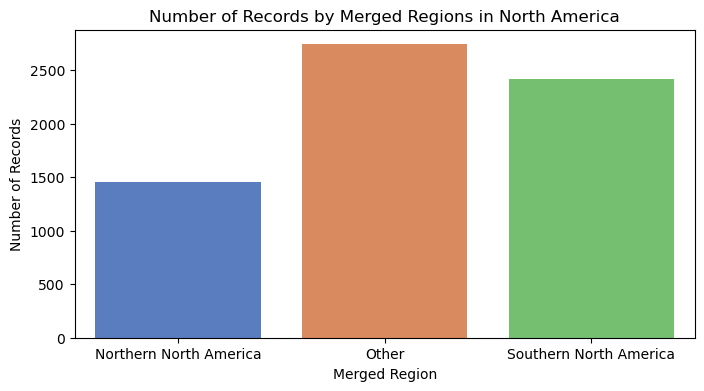

In [ ]:
def merge_regions(region): # Define a function to map old regions to new merged regions (North Vs South)

    if region in ['Northeast North America', 'Northwest North America']:
        return 'Northern North America'
    elif region in ['Southeast North America', 'Southwest North America']:
        return 'Southern North America'
    else:
        return 'Other'

df_1['merged_region'] = df_1['region'].apply(merge_regions)

merged_region_counts = df_1.groupby('merged_region').size()
print(merged_region_counts)

plt.figure(figsize=(8, 4))
sns.barplot(x=merged_region_counts.index, y=merged_region_counts.values, palette='muted')
plt.title('Number of Records by Merged Regions in North America')
plt.xlabel('Merged Region')
plt.ylabel('Number of Records')
plt.show()

#Subsets: 1: North North America. 2: South North America
#northern_north_america_df = df_1[df_1['merged_region'] == 'Northern North America']
#southern_north_america_df = df_1[df_1['merged_region'] == 'Southern North America']

In [ ]:
#Now we do the same process for Europe

europe_df = df_1[df_1['Continent'] == 'Europe']

# Count the number of records
europe_record_count = europe_df.shape[0]

# Print the count
print("Number of records for Europe:", europe_record_count)



Number of records for Europe: 999


In [ ]:
european_countries = [
    'Albania', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium',
    'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic',
    'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece',
    'Hungary', 'Iceland', 'Ireland', 'Italy', 'Kazakhstan', 'Kosovo', 'Latvia',
    'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova', 'Monaco',
    'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal',
    'Romania', 'Russia', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain',
    'Sweden', 'Switzerland', 'Turkey', 'Ukraine', 'United Kingdom', 'Vatican City'
]

europe = df_1[df_1['Country'].isin(european_countries)]

top_ten_countries = europe['Country'].value_counts().head(10)

# Print the top ten country counts
print("Top ten European countries by record count:")
print(top_ten_countries)

Top ten European countries by record count:
Country
United Kingdom    661
Germany            66
Spain              36
Ireland            36
France             28
Netherlands        26
Denmark            19
Switzerland        14
Belgium            14
Norway             14
Name: count, dtype: int64


Mean Sentiment Score for Northern North America: -0.03
Mean Sentiment Score for Southern North America: -0.06
Mean Sentiment Score for Europe: -0.01
Mean Sentiment Score for Global Sentiment: -0.04


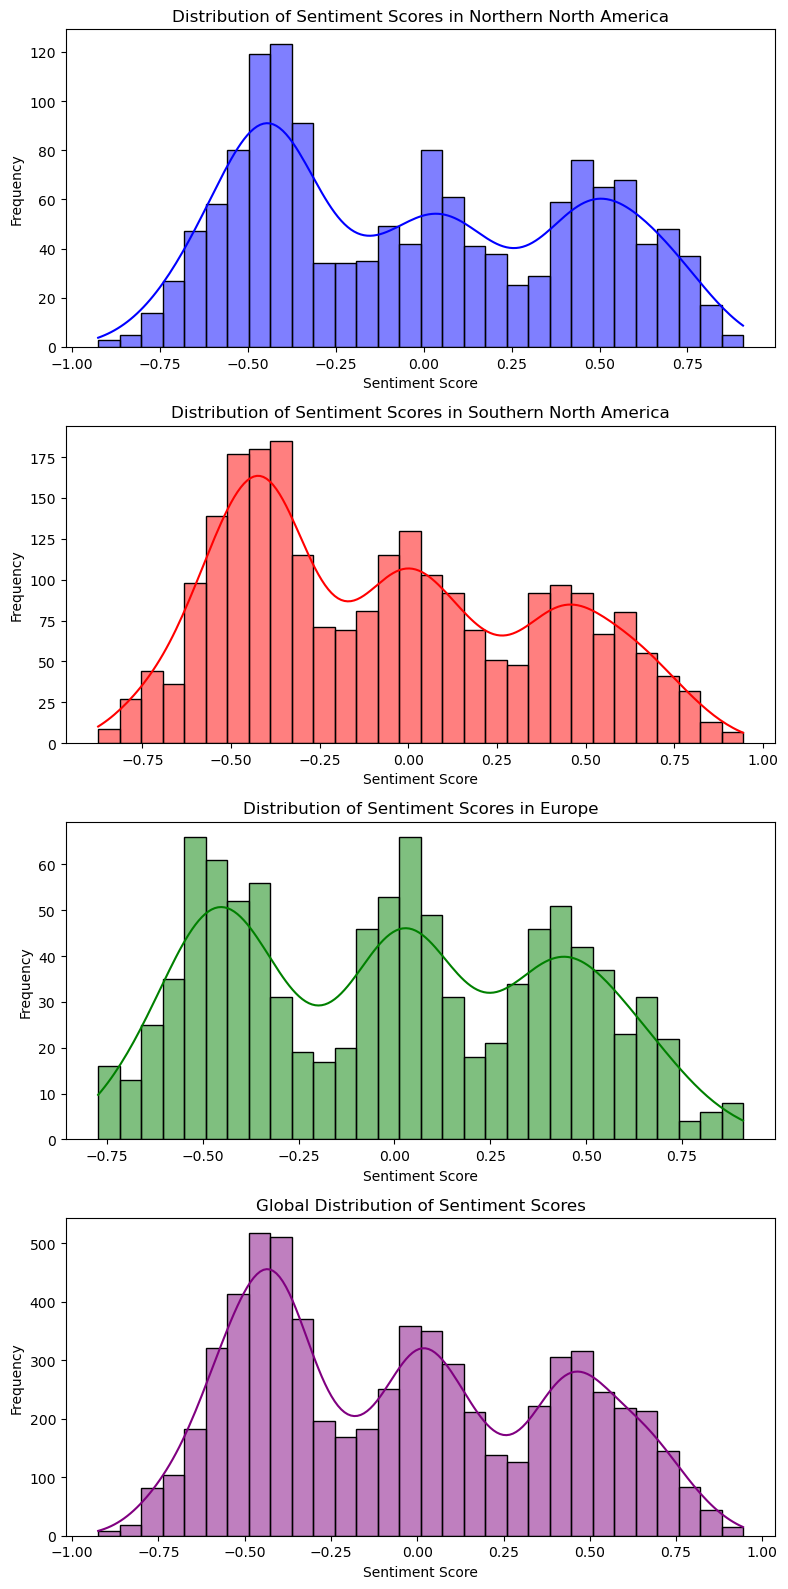

In [ ]:
#we will be using europe as a subset with 1000 rows
#Subsets: 1: North North America. 2: South North America
northern_north_america_df = df_1[df_1['merged_region'] == 'Northern North America']
southern_north_america_df = df_1[df_1['merged_region'] == 'Southern North America']
europe_df = df_1[df_1['Continent'] == 'Europe']

mean_sentiment_northern = northern_north_america_df['sentiment'].mean()
mean_sentiment_southern = southern_north_america_df['sentiment'].mean()
mean_sentiment_europe = europe_df['sentiment'].mean()
global_mean_sentiment = df_1['sentiment'].mean()

print(f"Mean Sentiment Score for Northern North America: {mean_sentiment_northern:.2f}")
print(f"Mean Sentiment Score for Southern North America: {mean_sentiment_southern:.2f}")
print(f"Mean Sentiment Score for Europe: {mean_sentiment_europe:.2f}")
print(f"Mean Sentiment Score for Global Sentiment: {global_mean_sentiment:.2f}")


fig, ax = plt.subplots(4, 1, figsize=(8, 16))

# Histogram/Density Plot for Northern North America
sns.histplot(northern_north_america_df['sentiment'], bins=30, kde=True, ax=ax[0], color="blue")
ax[0].set_title('Distribution of Sentiment Scores in Northern North America')
ax[0].set_xlabel('Sentiment Score')
ax[0].set_ylabel('Frequency')

# Histogram/Density Plot for Southern North America
sns.histplot(southern_north_america_df['sentiment'], bins=30, kde=True, ax=ax[1], color="red")
ax[1].set_title('Distribution of Sentiment Scores in Southern North America')
ax[1].set_xlabel('Sentiment Score')
ax[1].set_ylabel('Frequency')

# Histogram/Density Plot for Europe
sns.histplot(europe_df['sentiment'], bins=30, kde=True, ax=ax[2], color="green")
ax[2].set_title('Distribution of Sentiment Scores in Europe')
ax[2].set_xlabel('Sentiment Score')
ax[2].set_ylabel('Frequency')

# Histogram for Global Sentiment
sns.histplot(df_1['sentiment'], bins=30, kde=True, ax=ax[3], color="purple")
ax[3].set_title('Global Distribution of Sentiment Scores')
ax[3].set_xlabel('Sentiment Score')
ax[3].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
def calculate_percentage_of_believers(df, column_name='stance'):
    believers_count = (df[column_name] == 'believer').sum()
    total_count = len(df)
    percentage = (believers_count / total_count) * 100
    return percentage

percentage_northern = calculate_percentage_of_believers(northern_north_america_df)
percentage_southern = calculate_percentage_of_believers(southern_north_america_df)
percentage_europe = calculate_percentage_of_believers(europe_df)

print(f"Percentage of believers in Northern North America: {percentage_northern:.2f}%")
print(f"Percentage of believers in Southern North America: {percentage_southern:.2f}%")
print(f"Percentage of believers in Europe: {percentage_europe:.2f}%")

Percentage of believers in Northern North America: 42.63%
Percentage of believers in Southern North America: 41.28%
Percentage of believers in Europe: 43.04%
